# Census Population Data (2020) + NYC Tree Census Data (2015)

### Tress per capita (by Census Tract) 

### QUEENS

In [158]:
# load libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pysal as ps
import libpysal
import esda
from pysal.lib import weights
from splot.esda import plot_moran
from splot.esda import plot_local_autocorrelation

In [159]:
# read in data
trees_cts = gpd.read_file("data/trees_cts.geojson")

In [160]:
trees_cts.head()

,GEOID,population,census tract,county,tree_count,trees_per_capita,area_per_sqmile,trees_per_sqmile,geometry
0,36005012701,1664.0,127.01,Bronx,201.0,0.120793,0.041620,4829.377806,"POLYGON ((-7129744.449 4787818.802, -7129654.2..."
1,36005037300,4365.0,373,Bronx,211.0,0.048339,0.066843,3156.671549,"POLYGON ((-7129604.833 4789904.712, -7129520.2..."
2,36005011900,4276.0,119,Bronx,247.0,0.057764,0.063114,3913.558552,"POLYGON ((-7129505.357 4787665.982, -7129427.7..."
3,36005039100,5255.0,391,Bronx,364.0,0.069267,0.079709,4566.636743,"POLYGON ((-7129221.590 4790683.165, -7129136.5..."
4,36005007900,4957.0,79,Bronx,297.0,0.059915,0.076384,3888.228621,"POLYGON ((-7131068.335 4786855.710, -7130944.4..."


In [161]:
# check county names
print(trees_cts['county'].drop_duplicates().to_list())

['Bronx', 'Kings', 'Queens', 'Richmond', 'New York']


In [162]:
# look at only Queens
QN_trees_cap = trees_cts.query("county == 'Queens'")

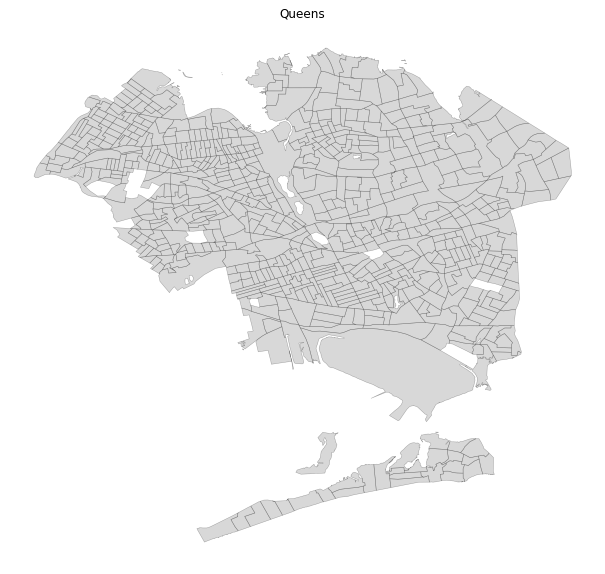

In [163]:
# check plot

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
QN_trees_cap.plot(ax = ax, alpha = 0.3, edgecolor = 'black', linewidth = 0.5, color = 'gray')

ax.axis('off')
ax.set(title = 'Queens')

plt.savefig("maps/Queens/Queens_CTs.pdf")

In [63]:
# first - drop cells containing Null values (cells containing zero points) - or code will not work
QN_trees_cap = QN_trees_cap.dropna(subset = ['trees_per_capita'])

In [64]:
# drop trees per capita with 0
QN_trees_cap = QN_trees_cap.query("trees_per_capita > 0")

In [71]:
# check min value
QN_trees_cap['trees_per_capita'].min()

0.003281219841729396

In [72]:
# check max value
QN_trees_cap['trees_per_capita'].max()

141.5

In [73]:
w_QN = weights.Queen.from_dataframe(QN_trees_cap)

In [74]:
w_QN = weights.KNN.from_dataframe(QN_trees_cap, k=1)

In [75]:
w_QN = weights.attach_islands(w_QN, w_knn_QN)

There are no disconnected observations (no islands)!


In [76]:
# row standardize weights
w_QN.transform = 'R'

## Spatial Autocorrelation - Local Moran's I
### *removed all census tracts with 0 trees per capita*

In [77]:
# on trees per capita
local_moran_QN = esda.moran.Moran_Local(QN_trees_cap['trees_per_capita'], w_QN)

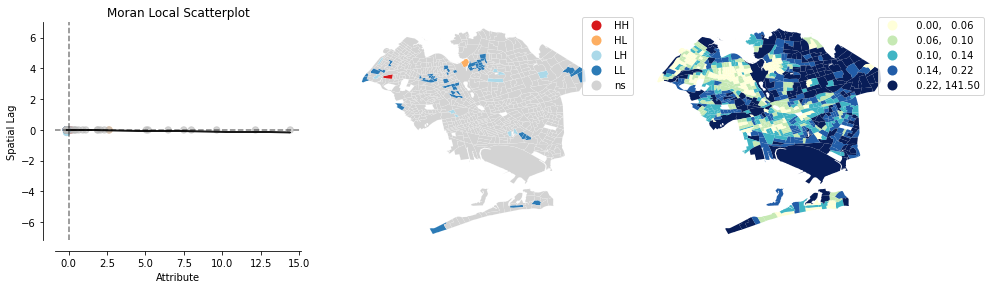

In [78]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_QN, QN_trees_cap,'trees_per_capita', p = 0.05 );

plt.savefig("maps/Queens/Queens_Trees-per-Capita_moran.pdf")

In [80]:
# get clusters and outliers - adding columns to the DF

QN_trees_cap['local_moran_Is'] = local_moran_QN.Is
QN_trees_cap['local_moran_p_value'] = local_moran_QN.p_sim
QN_trees_cap['local_moran_quadrant'] = local_moran_QN.q

In [81]:
# get statisically significant clusters and outliers

alpha = 0.05
hotspots_QN = QN_trees_cap.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_QN = QN_trees_cap.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_QN = QN_trees_cap.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_QN = QN_trees_cap.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

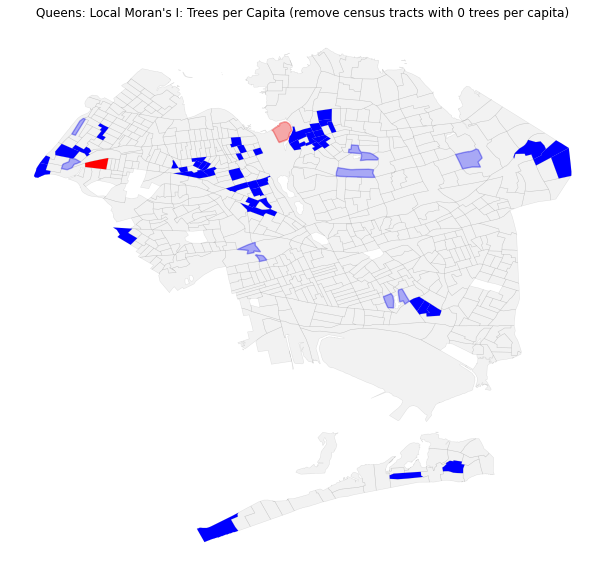

In [82]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
QN_trees_cap.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
QN_trees_cap.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_QN.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_QN.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_QN.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_QN.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Queens: Local Moran's I: Trees per Capita (remove census tracts with 0 trees per capita)")

plt.savefig("maps/Queens/Queens_Trees-per-Capita.pdf")

### *investigate the numbers*

In [132]:
# look at smallest values
QN_trees_cap['trees_per_capita'].nsmallest(n=10)

2115    0.003281
1164    0.008906
2229    0.011954
844     0.014695
711     0.015579
148     0.021493
167     0.021898
1806    0.021909
2267    0.021995
1718    0.023460
Name: trees_per_capita, dtype: float64

In [134]:
# look at largest values
QN_trees_cap['trees_per_capita'].nlargest(n=10)

940     141.500000
1490    119.500000
1362     95.000000
1139     79.000000
2107     74.200000
2137     64.333333
2130     51.666667
1861     50.500000
529      27.000000
845      26.833333
Name: trees_per_capita, dtype: float64

In [85]:
# lowest 1% of data
print(QN_trees_cap['trees_per_capita'].quantile(q = 0.01))

0.02191434926870786


In [86]:
# lowest 5% of data
print(QN_trees_cap['trees_per_capita'].quantile(q = 0.05))

0.03717773099040178


In [87]:
# lowest 10% of data
print(QN_trees_cap['trees_per_capita'].quantile(q = 0.10))

0.04688875136986038


In [88]:
# lowest 20% of data
print(QN_trees_cap['trees_per_capita'].quantile(q = 0.20))

0.0629552664100566


In [89]:
# highest 1% of data
print(QN_trees_cap['trees_per_capita'].quantile(q = 0.99))

49.08999999999861


In [90]:
# highest 5% of data
print(QN_trees_cap['trees_per_capita'].quantile(q = 0.95))

0.4591728346234246


In [91]:
# highest 10% of data
print(QN_trees_cap['trees_per_capita'].quantile(q = 0.90))

0.2929718264867572


In [92]:
# highest 20% of data
print(QN_trees_cap['trees_per_capita'].quantile(q = 0.80))

0.21714382109118952


## Spatial Autocorrelation - Local Moran's I - limited
### *removed all census tracts with less than 0.02 and more than 10  trees per capita*

In [97]:
# limit the range
QN_trees_cap_limit = QN_trees_cap.query("trees_per_capita > 0.02 & trees_per_capita < 10")

In [118]:
w_QN2 = weights.Queen.from_dataframe(QN_trees_cap_limit)

In [119]:
w_QN2 = weights.KNN.from_dataframe(QN_trees_cap_limit, k=1)

In [120]:
w_QN2 = weights.attach_islands(w_QN2, w_knn_QN2)

There are no disconnected observations (no islands)!


In [121]:
# row standardize weights
w_QN2.transform = 'R'

In [122]:
# on trees per capita
local_moran_QN2 = esda.moran.Moran_Local(QN_trees_cap_limit['trees_per_capita'], w_QN2)

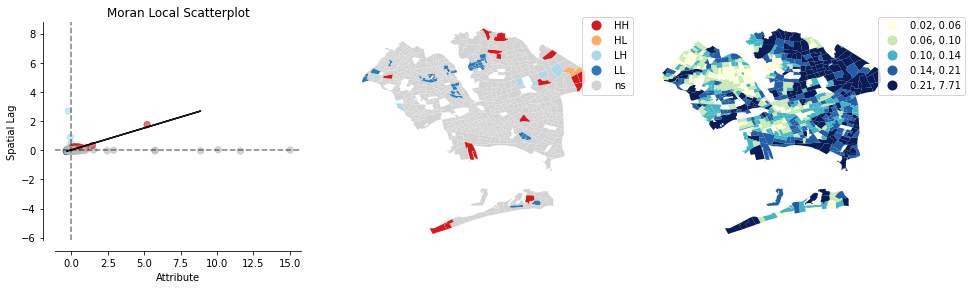

In [123]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_QN2, QN_trees_cap_limit,'trees_per_capita', p = 0.05 );

plt.savefig("maps/Queens/Queens_Trees-per-Capita_limited_moran.pdf")

In [125]:
# get clusters and outliers
QN_trees_cap_limit['local_moran_Is'] = local_moran_QN2.Is
QN_trees_cap_limit['local_moran_p_value'] = local_moran_QN2.p_sim
QN_trees_cap_limit['local_moran_quadrant'] = local_moran_QN2.q

In [126]:
# get statisically significant clusters and outliers
alpha = 0.05
hotspots_QN2 = QN_trees_cap_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_QN2 = QN_trees_cap_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_QN2 = QN_trees_cap_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_QN2 = QN_trees_cap_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

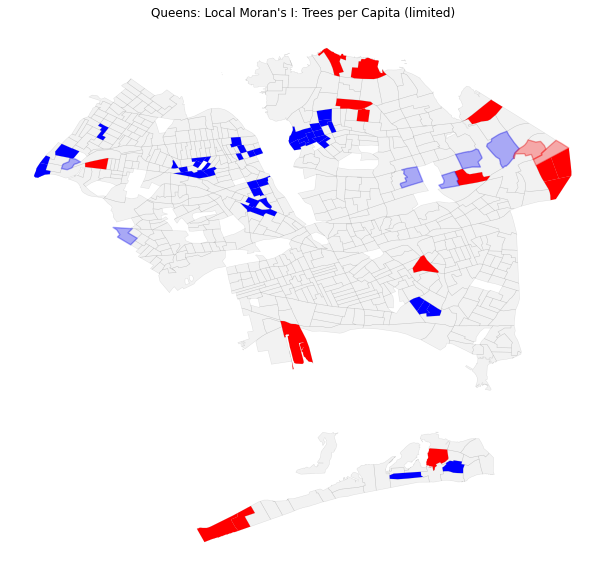

In [127]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
QN_trees_cap_limit.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
QN_trees_cap_limit.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_QN2.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_QN2.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_QN2.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_QN2.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Queens: Local Moran's I: Trees per Capita (limited)")

plt.savefig("maps/Queens/Queens_Trees-per-Capita_limited.pdf")

## Spatial Autocorrelation - Local Moran's I - more limited
### *removed all census tracts with less than 0.04 and more than 1  trees per capita*

In [144]:
# limit the range
QN_trees_cap_limit_more = QN_trees_cap.query("trees_per_capita > 0.04 & trees_per_capita < 1")

In [146]:
w_QN3 = weights.Queen.from_dataframe(QN_trees_cap_limit_more)

In [148]:
w_QN3 = weights.KNN.from_dataframe(QN_trees_cap_limit_more, k=1)

In [ ]:
w_QN3 = weights.attach_islands(w_QN3, w_knn_QN3)

In [151]:
# row standardize weights
w_QN3.transform = 'R'

In [152]:
# on trees per capita
local_moran_QN3 = esda.moran.Moran_Local(QN_trees_cap_limit_more['trees_per_capita'], w_QN3)

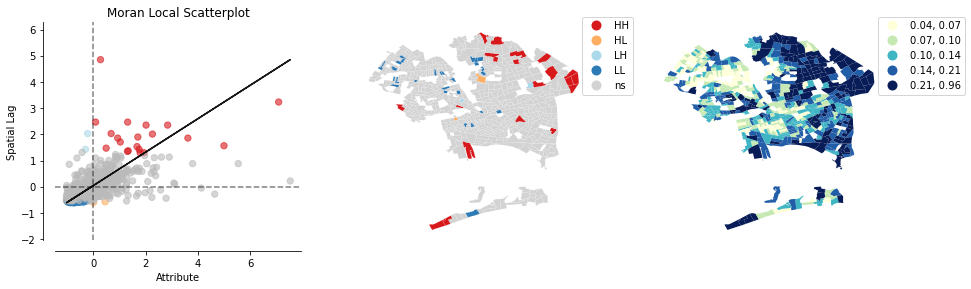

In [153]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_QN3, QN_trees_cap_limit_more,'trees_per_capita', p = 0.05 );

plt.savefig("maps/Queens/Queens_Trees-per-Capita_more-limited_moran.pdf")

In [155]:
# get clusters and outliers
QN_trees_cap_limit_more['local_moran_Is'] = local_moran_QN3.Is
QN_trees_cap_limit_more['local_moran_p_value'] = local_moran_QN3.p_sim
QN_trees_cap_limit_more['local_moran_quadrant'] = local_moran_QN3.q

In [156]:
# get statisically significant clusters and outliers
alpha = 0.05
hotspots_QN3 = QN_trees_cap_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_QN3 = QN_trees_cap_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_QN3 = QN_trees_cap_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_QN3 = QN_trees_cap_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

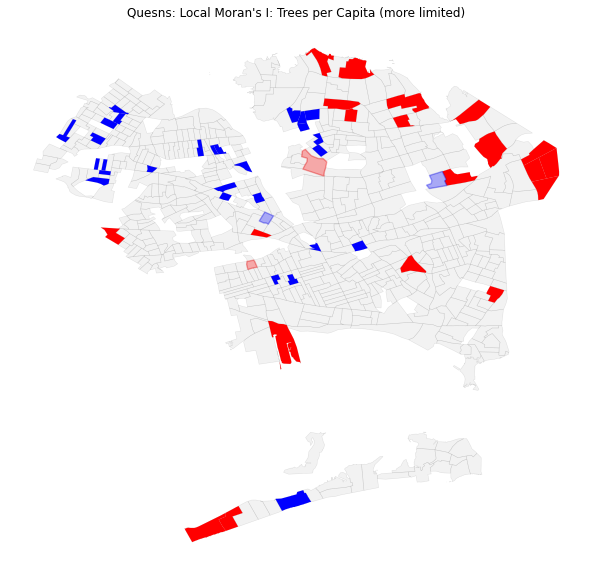

In [157]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
QN_trees_cap_limit_more.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
QN_trees_cap_limit_more.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_QN3.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_QN3.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_QN3.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_QN3.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Quesns: Local Moran's I: Trees per Capita (more limited)")

plt.savefig("maps/Queens/Queens_Trees-per-Capita_more-limited.pdf")